In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import h5py
import time
from random import sample
import datetime
from collections import Counter
import pickle
from tqdm import tqdm
import json
import statistics as stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import sparse_categorical_crossentropy
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

plt.rcParams.update({'figure.max_open_warning': 0})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
root_dir = '/content/gdrive/My Drive/'
base_dir = root_dir + 'Northwestern/Artificial Intelligence and Deep Learning/assignment_4/'

Mounted at /content/gdrive


Importing Raw Data

In [4]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
np.shape(train_images), np.shape(train_labels), np.shape(test_images), np.shape(test_labels)

170500096/170498071 [==============================] - 11s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [0]:
def raw_data():
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    data = {}
    data['train_images'] = train_images
    data['test_images'] = test_images
    data['train_labels'] = train_labels
    data['test_labels'] = test_labels
    return data

Exploring Raw Data

Text(0.5, 0, 'Classes')

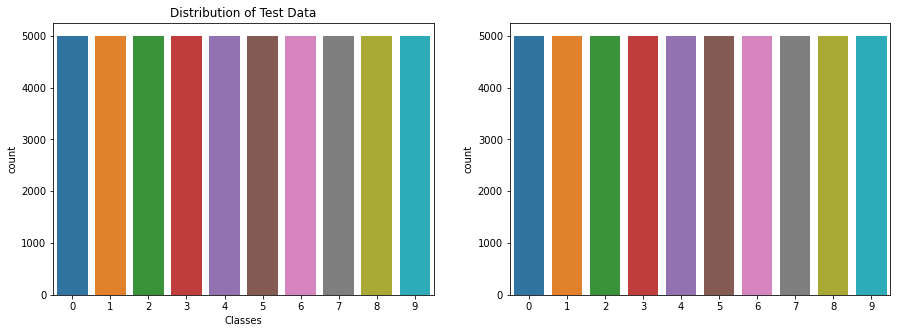

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.countplot(train_labels.ravel(), ax = ax[0])
ax[0].set_title('Distribution of Training Data')
ax[0].set_xlabel('Classes')

sns.countplot(train_labels.ravel(), ax = ax[1])
ax[0].set_title('Distribution of Test Data')
ax[0].set_xlabel('Classes')

In [0]:
def basic_exploration(data):
    train_images = data['train_images']
    test_images = data['test_images']
    print(f'The maximum training pixel value is {np.max(train_images.ravel())}')
    print(f'The minimum training pixel value is {np.min(train_images.ravel())}')
    print(f'The maximum test pixel value is {np.max(test_images.ravel())}')
    print(f'The minimum test pixel value is {np.min(test_images.ravel())}')

In [10]:
basic_exploration(raw_data())

The maximum training pixel value is 255
The minimum training pixel value is 0
The maximum test pixel value is 255
The minimum test pixel value is 0


In [0]:
def plot_raw_images(data):
    x = data['train_images']

    nrows = 5
    ncols = 10
    n_images = nrows * ncols
    images = sample(list(x), n_images)

    fig, ax = plt.subplots(nrows, ncols, figsize = [12,8])
    for row in range(nrows):
        for column in range(ncols):
            ax[row, column].imshow(images[ncols*row + column], cmap = 'binary')
            ax[row, column].axis('off')

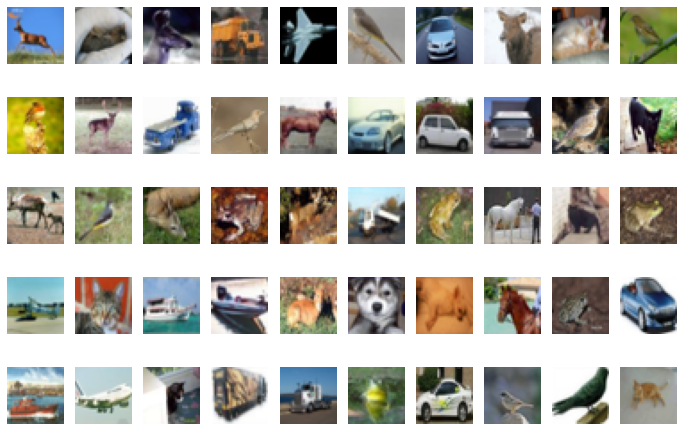

In [12]:
plot_raw_images(raw_data())

In [0]:
def get_null_values(data):
    print(f'Number of null values in training data is {np.isnan(data["train_images"]).sum()}')
    print(f'Number of null values in testing data is {np.isnan(data["test_images"]).sum()}')

In [23]:
get_null_values(raw_data())

Number of null values in training data is 0
Number of null values in testing data is 0


Prepare data by reshaping and separating into splits

In [0]:
def prepare_data(data, dense = False):

    train_images = data['train_images']
    test_images = data['test_images']
    train_labels = data['train_labels']
    test_labels = data['test_labels']
    train_images = train_images.astype('float32') / 255
    test_images = test_images.astype('float32') / 255
    if dense == True:
        train_images = train_images.reshape((train_images.shape[0],
                    train_images.shape[1] * train_images.shape[2] * 3))
        test_images = test_images.reshape((test_images.shape[0], 
                    test_images.shape[1] * test_images.shape[2] * 3))
    val_images, train_images = train_images[:5000], train_images[5000:]
    val_labels, train_labels = train_labels[:5000], train_labels[5000:]

    data = {}
    data['train_images'] = train_images
    data['val_images'] = val_images
    data['test_images'] = test_images
    data['train_labels'] = train_labels
    data['val_labels'] = val_labels
    data['test_labels'] = test_labels
    return data

In [0]:
def prepare_slices(data):
    train_ds = tf.data.Dataset.from_tensor_slices((data['train_images'], data['train_labels'])).shuffle(100).batch(64)
    val_ds = tf.data.Dataset.from_tensor_slices((data['val_images'], data['val_labels'])).batch(64)
    test_ds = tf.data.Dataset.from_tensor_slices((data['test_images'], data['test_labels']))
    slices = {}
    slices['train'] = train_ds
    slices['val'] = val_ds
    slices['test'] = test_ds
    return slices

Build architecture for model

In [0]:
def build_model_1():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=regularizers.l2(0.05), input_shape = (32, 32, 3)))
    model.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=regularizers.l2(0.05)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(0.05)))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(10, activation = 'softmax'))

    model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

Setup structure for implementing gradient tape

In [0]:
def model_train(features, labels, model):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = loss_func(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss.update_state(loss)
    train_acc.update_state(labels, predictions)
    return gradients

In [0]:
def model_validate(features, labels, model):
    predictions = model(features)
    v_loss = loss_func(labels, predictions)

    valid_loss.update_state(v_loss)
    valid_acc.update_state(labels, predictions)

Create directories and paths to save the data

In [0]:
def create_directory(model_name):
    file_path = base_dir + 'tests/' + model_name
    os.mkdir(file_path)

In [0]:
def write_to_file(data, model_name, model, save_weights = True):
    file_path = base_dir + 'tests/' + model_name + '/'
    if isinstance(data, dict):
        data_length = len(data)
        for key in data.keys():
            try:
                np.save(file_path + key, data[key], allow_pickle = True)
            except:
                with open(file_path + key, 'wb') as fout:
                    pickle.dump(data[key], fout)
    else:
        raise Exception('File is not a dict so something is wrong')

    with open(file_path + 'model_summary.txt','w') as fh:
        model.summary(print_fn=lambda x: fh.write(x + '\n'))

In [0]:
def model_check(model_name):
    file_path = base_dir + 'tests/'
    if os.path.isdir(file_path + model_name):
        raise Exception(f'file path {file_path + model_name} already exists')
    else:
        pass

Calculate statistics to measure

In [0]:
def get_samples(train_images):
    sample_size = range(len(train_images))
    sample_indexes = sample(sample_size, 10) 
    train_samples = train_images[tuple([sample_indexes])]
    return train_samples

In [0]:
def get_activations(model, train_samples):
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = tf.keras.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(train_samples)
    return activations

In [0]:
def calculate_pcount(flattened_values):
    threshold = np.mean(np.abs(flattened_values)) * 0.5
    thresh_count = np.sum(flattened_values < threshold)
    total_count = len(flattened_values)
    thresh_count_percentile = thresh_count / total_count
    return thresh_count_percentile

In [0]:
def sparse_neurons(flattened_values):
    zero_activations = np.sum(flattened_values == 0)
    total_activations = len(flattened_values)
    percent_zero = zero_activations / total_activations
    return percent_zero

In [0]:
def get_statistics(parameters):
    stats_and_values = {}
    statistics = {}
    flattened_values_dict = {}
    for key in parameters.keys():
        if key == 'weights':
            weights_variance = {}
            weights_max = {}
            weights_flattened = {}
            weights_bel_tresh = {}
            for i in range(len(parameters[key][0])):
                weights_variance[i] = []
                weights_max[i] = []
                weights_flattened[i] = []
                weights_bel_tresh[i] = []
                for epoch in range(len(parameters[key])):                                        
                    if len(parameters[key][epoch][i]) > 0:
                        flattened_values = np.reshape(parameters[key][epoch][i][0], -1)
                        weights_flattened[i].append(flattened_values)
                        weights_variance[i].append(np.var(flattened_values))
                        weights_max[i].append(max(flattened_values))
                        weights_bel_tresh[i].append(calculate_pcount(flattened_values))
            statistics['weights_variance'] = weights_variance
            statistics['weights_max'] = weights_max
            statistics['weights_bel_tresh'] = weights_bel_tresh
            flattened_values_dict['weights_flattened'] = weights_flattened
        if key == 'gradients':
            gradients_variance = {}
            gradients_max = {}
            gradients_flattened = {}
            gradients_bel_tresh = {}
            for i in range(len(parameters[key][0])):
                gradients_variance[i] = []
                gradients_max[i] = []
                gradients_flattened[i] = []
                gradients_bel_tresh[i] = []
                for epoch in range(len(parameters[key])):
                    flattened_values = np.reshape(parameters[key][epoch][i], -1) 
                    gradients_variance[i].append(np.var(flattened_values))
                    gradients_max[i].append(max(flattened_values))
                    gradients_flattened[i].append(flattened_values)
                    gradients_bel_tresh[i].append(calculate_pcount(flattened_values))
            statistics['gradients_variance'] = gradients_variance
            statistics['gradients_max'] = gradients_max
            statistics['weights_bel_tresh'] = weights_bel_tresh
            flattened_values_dict['gradients_flattened'] = gradients_flattened
        if key == 'activations':
            activations_variance = {}
            activations_max = {}
            activations_flattened = {}
            activations_bel_tresh = {}
            activations_sparse_neurons = {}
            for i in range(len(parameters[key][0])):
                activations_variance[i] = []
                activations_max[i] = []
                activations_flattened[i] = []
                activations_bel_tresh[i] = []
                activations_sparse_neurons[i] = []
                for epoch in range(len(parameters[key])):
                    flattened_values = np.reshape(parameters[key][epoch][i], -1) 
                    activations_variance[i].append(np.var(flattened_values))
                    activations_max[i].append(max(flattened_values))
                    activations_flattened[i].append(flattened_values)
                    activations_bel_tresh[i].append(calculate_pcount(flattened_values))
                    activations_sparse_neurons[i].append(sparse_neurons(flattened_values))
            statistics['activations_variance'] = activations_variance
            statistics['activations_max'] = activations_max
            statistics['activations_bel_tresh'] = activations_bel_tresh
            statistics['activations_sparse_neurons'] = activations_sparse_neurons
            flattened_values_dict['activations_flattened'] = activations_flattened
    stats_and_values['statistics'] = statistics
    stats_and_values['flattened_values'] = flattened_values_dict
    return stats_and_values

In [0]:
def get_summary_statistics(statistics, model_name):
    statistics = statistics['statistics']
    summary_statistics = {}
    for key in statistics.keys():
        layers_statistics = []
        for layer in statistics[key].keys():
            try:
                if len(statistics[key][layer]) > 0:
                    layers_statistics.append(statistics[key][layer][-1])
            except:
                raise Exception(key, layer)
        summary_statistics[key] = np.mean(layers_statistics)
    df_summary_statistics = pd.DataFrame(summary_statistics, index = [model_name])
    return df_summary_statistics

Create tables to summarize performance and statistics

In [0]:
def summary_performance(performance, model_name):
    summary_statistics = {}    
    for key in performance.keys():
        try:
            summary_statistics[key] = performance[key][-1]
        except:
            summary_statistics[key] = performance[key]
    df_summary_statistics = pd.DataFrame(summary_statistics.items(), columns = ['index', model_name])
    df_summary_statistics = df_summary_statistics.set_index('index').T
    return df_summary_statistics

In [0]:
def summary_table(performance, statistics, model_name):
    df_performance = summary_performance(performance, model_name)
    df_statistics = get_summary_statistics(statistics, model_name)
    file_path = base_dir + 'tests/summary_table.csv'
    if os.path.exists(file_path):
        df_table = pd.read_csv(file_path, index_col = 0)
    else:
        df_table = pd.DataFrame()
    df_results = pd.concat([df_performance, df_statistics], axis = 1)
    df_table = pd.concat([df_table, df_results])
    df_table.to_csv(file_path, index = True)
    return df_table

In [0]:
def comparison_table():
    file_path_comparison = base_dir + 'tests/comparison_summary_table.csv'
    file_path_summary = base_dir + 'tests/summary_table.csv'
    if os.path.exists(file_path_comparison):
        df_table = pd.read_csv(file_path_comparison, index_col = 0)
    else:
        df_table = pd.DataFrame()
    df_summary = pd.read_csv(file_path_summary, index_col = 0)
    df_comparison_results = df_summary.iloc[-1,:] / df_summary.loc['baseline', :]
    model_name = df_summary.index[-1]
    df_comparison_results = pd.DataFrame(df_comparison_results, columns = [model_name]).T
    df_table = pd.concat([df_table, df_comparison_results])
    df_table.to_csv(file_path_comparison, index = True)
    return df_table

Create plots to summarize statistics

In [0]:
def plot_layer_statistics_cons(statistics, model_name):
    statistics = statistics['statistics']
    plots = len(statistics.keys())
    fig, ax = plt.subplots(plots, figsize = [15,40])

    for row, parameter in enumerate(statistics.keys()):
        num_layers = len(statistics[parameter])
        for layer in range(len(statistics[parameter])):
            if len(statistics[parameter][layer]) > 0:
                ax[row].plot(statistics[parameter][layer])
        ax[row].set_title(f'{parameter} through epochs')
        ax[row].legend(range(num_layers))
        
    file_path = base_dir + 'tests/' + model_name + '/layer_statistics_consolidated.png'
    fig.savefig(file_path)

In [0]:
def plot_layer_statistics(statistics, model_name):
    statistics = statistics['statistics']
    plot_per_row = len(statistics.keys())
    plot_per_column = len(statistics['gradients_variance'])
    fig, ax = plt.subplots(plot_per_column, plot_per_row, figsize = [10,10])
    fig.suptitle(statistics.keys())

    for col, parameter in enumerate(statistics.keys()):
        for row, layer in enumerate(range(len(statistics[parameter]))):
            if len(statistics[parameter][layer]) > 0:
                ax[row, col].plot(statistics[parameter][layer])

    file_path = base_dir + 'tests/' + model_name + '/layer_statistics.png'
    fig.savefig(file_path)                

In [0]:
def plot_statistics_dist(statistics, model_name):
    sns.set_style("whitegrid", {'axes.grid' : False})
    flattened_values = statistics['flattened_values']
    plot_per_row = len(flattened_values.keys())
    plot_per_column = len(flattened_values['gradients_flattened'])
    fig, ax = plt.subplots(plot_per_column, plot_per_row, figsize = [10,10])
    fig.suptitle(flattened_values.keys())

    for col, parameter in enumerate(flattened_values.keys()):
        for row, layer in enumerate(range(len(flattened_values[parameter]))):
            if len(flattened_values[parameter][layer]) > 0:           
                sns.distplot(flattened_values[parameter][layer], bins = 20, ax=ax[row, col], hist = False)

    file_path = base_dir + 'tests/' + model_name + '/statistics_distributions.png'
    fig.savefig(file_path)

In [0]:
def write_to_statistics(file_name, data, model_name):
    file_path = base_dir + 'tests/' + model_name  + '/' + file_name + '.json'
    with open(file_path, 'w') as fout:
        json.dump(data, fout)

In [0]:
def return_statistics_summary(parameters, model_name):
    statistics = parameters['statistics']
    param_keys = {}
    param_keys_summary = {}
    for key in statistics.keys():
        param_list = []
        param_list_summary = []
        for layer in statistics[key]:
            if len(statistics[key][layer]) > 0:
                layer_list = []
                for value in range(len(statistics[key][layer])):
                    layer_list.append(statistics[key][layer][value].astype('float'))
                layer_summary = stats.mean(layer_list)
            param_list.append(layer_list)
            param_list_summary.append(layer_summary)
        param_keys[key] = param_list
        param_keys_summary[key] = param_list_summary
    
    write_to_statistics('stats_layer', param_keys, model_name)
    write_to_statistics('stats_summary', param_keys_summary, model_name)


In [0]:
def plot_results(performance, model_name):

    epochs = range(1, len(performance['train_acc_history']) + 1)

    fig, ax = plt.subplots(1,2, figsize = [15, 6])
    ax[0].plot(epochs, performance['train_loss_history'], 'bo', label = 'Training loss')
    ax[0].plot(epochs, performance['val_loss_history'], 'b', label = 'Validation loss')

    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, performance['train_acc_history'], 'bo', label = 'Training accuracy')
    ax[1].plot(epochs, performance['val_acc_history'], 'b', label = 'Validation accuracy')

    ax[1].set_title('Training and Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    file_path = base_dir + 'tests/' + model_name + '/summary_performance.png'
    fig.savefig(file_path)

Prepare models to run

In [0]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
valid_loss = tf.keras.metrics.Mean(name="test_loss")

train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="train_acc")
valid_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="valid_acc")
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="test_acc")

loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.RMSprop()

In [0]:
def model_run(data, model, model_name):
    model_check(model_name)
    create_directory(model_name)
    keras.backend.clear_session()

    slices = prepare_slices(data)
    train_data = slices['train']
    val_data = slices['val']
    train_samples = get_samples(data['train_images'])
    EPOCHS = 30
    performance = {}
    parameters = {}
    performance['train_acc_history'] = []
    performance['train_loss_history'] = []
    performance['val_acc_history'] = []
    performance['val_loss_history'] = []
    parameters['weights'] = []
    parameters['activations'] = []
    parameters['gradients'] = []
    elapsed_time_tot = []

    for epoch in tqdm(range(EPOCHS)):

        start_time = time.time()
        for features, labels in train_data:
            grad = model_train(features, labels, model)

        
        for val_features, val_labels in val_data:
            model_validate(val_features, val_labels, model)

        loss, acc = train_loss.result(), train_acc.result()
        val_loss, val_acc = valid_loss.result(), valid_acc.result()

        performance['train_acc_history'].append(round(acc.numpy(), 4))
        performance['train_loss_history'].append(round(loss.numpy(), 4))
        performance['val_acc_history'].append(round(val_acc.numpy(), 4))
        performance['val_loss_history'].append(round(val_loss.numpy(), 4))
        parameters['weights'].append([layer.get_weights() for layer in model.layers])
        parameters['gradients'].append(grad)
        parameters['activations'].append(get_activations(model, train_samples))

        train_loss.reset_states(), train_acc.reset_states()
        valid_loss.reset_states(), valid_acc.reset_states()

        end_time = time.time()
        elapsed_time = round(end_time - start_time, 4)
        elapsed_time_tot.append(elapsed_time)
        template = """Epoch {}, loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}, elapsed time: {:.3f}"""
        print (template.format(epoch+1,
                            loss,
                            acc,
                            val_loss,
                            val_acc,
                            elapsed_time))

    test_results = model.evaluate(data['test_images'], data['test_labels'], batch_size = 64)      
    performance['test_accuracy'] = round(test_results[1], 4)
    performance['test_loss'] = round(test_results[0], 4)   
    elapsed_time_tot = [sum(elapsed_time_tot[0:x:1]) for x in range(1, EPOCHS+1)]
    performance['time_to_run'] = elapsed_time_tot
    performance['num_parameters'] = model.count_params()
    performance['parameter_efficiency'] = [round(i/performance['num_parameters']*1000, 4) for i in performance['time_to_run']]
    print(f"Test accuracy: {performance['test_accuracy']}, Test loss: {performance['test_loss']}")  
        
    return model, parameters, performance

Run models

In [0]:
def main(model_name, model, dense = False, save_data = True):
    model, parameters, performance = model_run(prepare_data(raw_data(), dense = dense), model, model_name)
    statistics = get_statistics(parameters)
    if save_data == True: 
        write_to_file(parameters, model_name, model)
    write_to_file(performance, model_name, model)
    summary_table(performance, statistics, model_name)
    comparison_table()
    return_statistics_summary(statistics, model_name)
    plot_results(performance, model_name)
    plot_layer_statistics(statistics, model_name)
    plot_layer_statistics_cons(statistics, model_name)
    plot_statistics_dist(statistics, model_name)

In [0]:
model_name = 'final_model'
model = build_model_1()
dense = False
save_data = False
main(model_name, model, dense = dense, save_data = save_data)

  3%|▎         | 1/30 [00:19<09:36, 19.88s/it]

Epoch 1, loss: 1.640, acc: 0.415, val_loss: 1.376, val_acc: 0.512, elapsed time: 19.883


  7%|▋         | 2/30 [00:39<09:18, 19.94s/it]

Epoch 2, loss: 1.042, acc: 0.638, val_loss: 1.089, val_acc: 0.637, elapsed time: 20.061


 10%|█         | 3/30 [01:00<09:03, 20.14s/it]

Epoch 3, loss: 0.766, acc: 0.735, val_loss: 1.216, val_acc: 0.606, elapsed time: 20.622


 13%|█▎        | 4/30 [01:20<08:44, 20.18s/it]

Epoch 4, loss: 0.569, acc: 0.804, val_loss: 1.446, val_acc: 0.585, elapsed time: 20.266


 17%|█▋        | 5/30 [01:41<08:25, 20.22s/it]

Epoch 5, loss: 0.425, acc: 0.856, val_loss: 1.094, val_acc: 0.726, elapsed time: 20.298


 20%|██        | 6/30 [02:01<08:05, 20.21s/it]

Epoch 6, loss: 0.329, acc: 0.892, val_loss: 1.182, val_acc: 0.696, elapsed time: 20.204


 23%|██▎       | 7/30 [02:21<07:43, 20.15s/it]

Epoch 7, loss: 0.276, acc: 0.910, val_loss: 1.656, val_acc: 0.724, elapsed time: 20.001


 27%|██▋       | 8/30 [02:41<07:23, 20.15s/it]

Epoch 8, loss: 0.250, acc: 0.921, val_loss: 1.485, val_acc: 0.742, elapsed time: 20.155


 30%|███       | 9/30 [03:01<07:00, 20.04s/it]

Epoch 9, loss: 0.241, acc: 0.932, val_loss: 1.351, val_acc: 0.723, elapsed time: 19.782


 33%|███▎      | 10/30 [03:21<06:39, 19.99s/it]

Epoch 10, loss: 0.217, acc: 0.937, val_loss: 1.472, val_acc: 0.715, elapsed time: 19.888


 37%|███▋      | 11/30 [03:41<06:19, 19.99s/it]

Epoch 11, loss: 0.214, acc: 0.941, val_loss: 1.570, val_acc: 0.719, elapsed time: 19.975


 40%|████      | 12/30 [04:01<06:00, 20.02s/it]

Epoch 12, loss: 0.202, acc: 0.945, val_loss: 1.518, val_acc: 0.743, elapsed time: 20.093


 43%|████▎     | 13/30 [04:21<05:40, 20.02s/it]

Epoch 13, loss: 0.195, acc: 0.950, val_loss: 3.337, val_acc: 0.665, elapsed time: 20.003


 47%|████▋     | 14/30 [04:40<05:18, 19.93s/it]

Epoch 14, loss: 0.201, acc: 0.950, val_loss: 2.106, val_acc: 0.734, elapsed time: 19.723


 50%|█████     | 15/30 [05:00<04:59, 19.95s/it]

Epoch 15, loss: 0.187, acc: 0.954, val_loss: 1.959, val_acc: 0.742, elapsed time: 19.988


 53%|█████▎    | 16/30 [05:20<04:39, 19.94s/it]

Epoch 16, loss: 0.190, acc: 0.956, val_loss: 1.724, val_acc: 0.677, elapsed time: 19.927


 57%|█████▋    | 17/30 [05:40<04:19, 19.93s/it]

Epoch 17, loss: 0.178, acc: 0.957, val_loss: 1.941, val_acc: 0.715, elapsed time: 19.907


 60%|██████    | 18/30 [06:00<03:59, 19.93s/it]

Epoch 18, loss: 0.185, acc: 0.957, val_loss: 2.329, val_acc: 0.731, elapsed time: 19.913


 63%|██████▎   | 19/30 [06:20<03:39, 20.00s/it]

Epoch 19, loss: 0.190, acc: 0.957, val_loss: 2.199, val_acc: 0.730, elapsed time: 20.171


 67%|██████▋   | 20/30 [06:40<03:20, 20.03s/it]

Epoch 20, loss: 0.194, acc: 0.959, val_loss: 2.455, val_acc: 0.722, elapsed time: 20.116


 70%|███████   | 21/30 [07:00<02:59, 19.98s/it]

Epoch 21, loss: 0.189, acc: 0.960, val_loss: 2.151, val_acc: 0.699, elapsed time: 19.864


 73%|███████▎  | 22/30 [07:20<02:39, 19.94s/it]

Epoch 22, loss: 0.187, acc: 0.961, val_loss: 2.042, val_acc: 0.740, elapsed time: 19.832


 77%|███████▋  | 23/30 [07:40<02:19, 19.91s/it]

Epoch 23, loss: 0.194, acc: 0.963, val_loss: 2.693, val_acc: 0.718, elapsed time: 19.846


 80%|████████  | 24/30 [08:00<01:59, 19.96s/it]

Epoch 24, loss: 0.191, acc: 0.962, val_loss: 2.645, val_acc: 0.732, elapsed time: 20.069


 83%|████████▎ | 25/30 [08:20<01:39, 19.97s/it]

Epoch 25, loss: 0.186, acc: 0.964, val_loss: 2.058, val_acc: 0.740, elapsed time: 20.003


 87%|████████▋ | 26/30 [08:40<01:19, 19.88s/it]

Epoch 26, loss: 0.200, acc: 0.963, val_loss: 3.116, val_acc: 0.722, elapsed time: 19.660


 90%|█████████ | 27/30 [08:59<00:59, 19.83s/it]

Epoch 27, loss: 0.201, acc: 0.965, val_loss: 2.340, val_acc: 0.737, elapsed time: 19.720


 93%|█████████▎| 28/30 [09:19<00:39, 19.84s/it]

Epoch 28, loss: 0.212, acc: 0.963, val_loss: 2.664, val_acc: 0.751, elapsed time: 19.875


 97%|█████████▋| 29/30 [09:39<00:19, 19.85s/it]

Epoch 29, loss: 0.223, acc: 0.964, val_loss: 3.555, val_acc: 0.618, elapsed time: 19.862


100%|██████████| 30/30 [10:00<00:00, 20.02s/it]

Epoch 30, loss: 0.217, acc: 0.963, val_loss: 3.007, val_acc: 0.756, elapsed time: 20.869


157/157 [==============================] - 1s 5ms/step - loss: 2727.7822 - accuracy: 0.7467
Test accuracy: 0.7467, Test loss: 2727.7822


Read summary tables

In [0]:
df_summary = pd.read_csv(base_dir + 'tests/summary_table.csv',index_col=0)
df_comp = pd.read_csv(base_dir + 'tests/comparison_summary_table.csv',index_col=0)

Prepare tests for statistics

In [0]:
def accuracy_vs_metrics(df_summary, y, clipped):
    cols_to_plot = df_summary.iloc[:,1:].columns
    num_plots = len(cols_to_plot)
    plots_per_row = 3
    num_rows = num_plots // plots_per_row + 1
    fig, ax = plt.subplots(num_rows, plots_per_row, figsize = [20, 15])
    fig.tight_layout()
    for row in range(num_rows):
        for col in range(plots_per_row):
            df_index = col + row * 3
            if df_index < num_plots:
                if clipped == True:
                # There was one value skewing the data so it was removed
                    clipped_df = df_summary.sort_values(cols_to_plot[df_index], ascending = False).iloc[2:]
                    sns.regplot(clipped_df[y], cols_to_plot[df_index],
                                data = clipped_df, ax = ax[row, col])
                elif clipped == False:
                    sns.regplot(df_summary[y], cols_to_plot[df_index],
                                data = df_summary, ax = ax[row, col])
                ax[row,col].set_title(f'{y} vs {cols_to_plot[df_index]}')
                ax[row,col].set_xlabel('')
                ax[row,col].set_ylabel('')
            else:
                pass

In [0]:
def correlation_heatmap(df_summary, test_id):
    plt.figure(figsize = [10,8])
    sns.heatmap(df_summary.corr(), annot=True)
    plt.title(f'{test_id} Correlations')

In [0]:
def plot_beta(df_summary, y, test_id):
    plt.figure()
    beta = df_summary.cov()[y] / df_summary[y].var()
    sns.heatmap(beta.to_frame(), annot=True)
    plt.title(f'{test_id} Beta')

In [0]:
def scale_data(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_data = pd.DataFrame(scaled_data, columns = df.columns, index = df.index)
    return scaled_data

In [0]:
def linear_regression(X, y, test_id):
    results = {}
    lr = LinearRegression()
    lr.fit(X, y)
    results['coef'] = lr.coef_
    results['score'] = lr.score(X, y)
    print(f'The Linear Regression R2 is {round(results["score"], 3)}')
    df_coef = pd.DataFrame(results['coef'], index = X.columns, columns = ['coefs'])
    plt.figure()
    sns.heatmap(df_coef, annot=True)
    plt.title(f'{test_id} Linear Regression Coefficients')
    return results['coef']

In [0]:
def random_forest_feature_importance(X, y, test_id):
    results = {}
    rf = RandomForestRegressor()
    rf.fit(X, y)
    results['feature_importance'] = rf.feature_importances_
    results['score'] = rf.score(X, y)
    print(f'The Random Forest R2 is {round(results["score"], 3)}')
    df_coef = pd.DataFrame(results['feature_importance'], index = X.columns, 
                           columns = ['feature_importance'])
    plt.figure()
    sns.heatmap(df_coef, annot=True)
    plt.title(f'{test_id} Random Forest Feature Importance')
    return results['feature_importance']

In [0]:
def get_tests_with_summaries():
    contain_layer_summaries = []
    notin_layer_summaries = []
    for test in os.listdir(base_dir + 'tests'):
        if 'CNN' in test:
            if 'stats_summary.json' in os.listdir(base_dir + 'tests/' + test):
                contain_layer_summaries.append(test)
            else:
                notin_layer_summaries.append(test)
    return contain_layer_summaries, notin_layer_summaries

In [0]:
def get_layer_summaries(df_summary, y_field):
    contain_layer_summaries = get_tests_with_summaries()[0]
    dir_path = base_dir + 'tests/'
    layer_stats = {}
    y_results = []
    for test in contain_layer_summaries[1:]:
        y_results.append(df_summary.loc[test, y_field])
        with open(dir_path + test + '/stats_summary.json') as f:
            stats_summary = json.load(f)    
            for key in stats_summary.keys():
                if layer_stats.get(key) is None:
                    layer_stats[key] = pd.DataFrame(stats_summary[key], columns = [test]).T                        
                else:                        
                    df_test = pd.DataFrame(stats_summary[key], columns = [test]).T
                    layer_stats[key] = pd.concat([layer_stats[key], df_test])
    
    return layer_stats, y_results                

In [0]:
layer_summary, y_results = get_layer_summaries(df_summary, 'test_accuracy')

In [0]:
def summary_analysis(df, y, indexer, test_id = None):
    if isinstance(indexer, str):
        correlation_heatmap(df.loc[:, y:], test_id)
        plot_beta(scale_data(df.loc[:,y:]), y, test_id)
        lr_coefs = linear_regression(scale_data(df.loc[:,indexer:]), df[y], test_id)
        rf_feature_importance = random_forest_feature_importance(scale_data(df.loc[:,indexer:]), df[y], test_id)
        accuracy_vs_metrics(df.loc[:,y:], y, clipped = True)
    elif isinstance(indexer, int):
        correlation_heatmap(df.loc[:, y:], test_id)
        plot_beta(scale_data(df.loc[:,y:]), y, test_id)
        lr_coefs = linear_regression(scale_data(df.iloc[:,indexer:]), df[y], test_id)
        rf_feature_importance = random_forest_feature_importance(scale_data(df.iloc[:,indexer:]), df[y], test_id)
        return lr_coefs, rf_feature_importance

In [0]:
def plot_statistics_results(df, y_results, y_field, indexer):
    y = pd.DataFrame(y_results, index = df['weights_variance'].index, columns = ['test_accuracy'])
    lr_coefs = pd.DataFrame()
    rf_feature_importances = pd.DataFrame()
    lr_scores = pd.DataFrame()
    rf_scores = pd.DataFrame()
    for key in df.keys():
        df_key = pd.concat([y, df[key]], axis=1)
        df_key.fillna(0, inplace=True)
        print(key)        
        lr_coef, rf_feature_importance = summary_analysis(df_key, y_field, indexer, key)
        lr_coef = pd.DataFrame(lr_coef)
        rf_feature_importance = pd.DataFrame(rf_feature_importance)
        lr_coefs = pd.concat([lr_coefs, lr_coef], axis =1)
        rf_feature_importances = pd.concat([rf_feature_importances, rf_feature_importance], axis =1)
    lr_coefs = scale_data(lr_coefs)
    lr_coefs.columns = df.keys()
    rf_feature_importances = scale_data(rf_feature_importances)
    rf_feature_importances.columns = df.keys()
    plt.figure()
    sns.heatmap(lr_coefs.dropna(), annot=True)
    plt.title('Coefficient Influence From Linear Regression')
    plt.figure()
    sns.heatmap(rf_feature_importances.dropna(), annot=True)
    plt.title('Feature Importance From Random Forest')        

In [0]:
df_summary.sort_values('test_accuracy', ascending = False)

train_acc_history  ...  gradients_max
3CNN_l_2do_64f_512f2_512f3_256d_128d_l2                      0.9453  ...       0.001278
4CNN_l_2do_32f_128f2_256f3_512f4_256d_128d_l2                0.9099  ...       0.043305
3CNN_l_2do_64f_256f2_256f3_256d_128d_l2                      0.9428  ...       0.005996
3CNN_l_2do_32f_128f2_256f3_128d_64d_l2                       0.9652  ...       0.031428
2CNN_layers_5do1l_256d_l2                                    0.9869  ...       0.000034
3CNN_l_2do_64f_128f2f3_128d_64d_l2                           0.9562  ...       0.014676
4CNN_l_2do_32f_64f2_128f3_256f4_128d_64d_bn                  0.9646  ...       0.009605
2CNN_layers_5do1l_256d                                       0.9869  ...       0.001850
2CNN_layers_2do_256d_2ll2                                    0.9864  ...       0.001356
2CNN_layers_1do_256d_2ll2                                    0.9862  ...       0.000111
4CNN_layers_2do_128d_128f_l2                                 0.9351  ...       0.588729
2CNN_layers_5do1l_256d                                       0.9860  ...       0.000146
4CNN_l_2do_32f_128f2_256f3_512f4_256d_128d                   0.9072  ...       1.131695
2CNN_layers_1do_64f_128f2_256d_128d_l2                       0.9761  ...       0.000000
4CNN_l_2do_64f_512f2f3f4_256d_128d_l2                        0.8504  ...       1.762225
2CNN_layers_1do_64f_128f2_128d_64d_l2                        0.9764  ...       0.007214
4CNN_l_2do_32f_128f2_256f3_512f4_256d_128d_bn                0.9420  ...       0.356344
2CNN_layers_256d_l2                                          0.9863  ...       0.219509
2CNN_l_2do_64f_128f2_256f3_256d_256d_128d_l2                 0.9432  ...       0.000026
3CNN_l_2do_32f_64f2_128f3_128d_64d_l2_bn                     0.9786  ...       0.002986
2CNN_layers_5do                                              0.9772  ...       0.001483
3CNN_l_2do_64ff2f3_64d_64d_l2                                0.9028  ...       0.134289
4CNN_layers                                                  0.9579  ...       4.425358
4CNN_l_2do_32f_128f2_256f3_512f4_256d_128d_l2_bn             0.9483  ...       0.597837
2CNN_l_64ff1_32d                                             0.9028  ...       0.129475
2CNN_l_2do_64f_128f2_256d_128d_l2_bn                         0.9818  ...       0.000008
3CNN_layers                                                  0.9581  ...       0.391638
4CNN_layers_2do_128d_128f_l1                                 0.9343  ...       0.041574
3CNN_l_32ff1_128f2_128d_do                                   0.9699  ...       0.000003
4CNN_l_2do_32f_64f2_128f3_128d_64d_bn                        0.9775  ...       1.499053
3CNN_l_3do_64f_128f2f3_128d_64d_l2                           0.9578  ...       1.841875
2CNN_layers_5do1l                                            0.9761  ...       0.011938
2CNN_layers                                                  0.9570  ...       0.397708
5CNN_l_128fs_128dd1_do_l2                                    0.9650  ...       0.029864
3CNN_l_32ff1_128f2_128d_do_bn                                0.9737  ...       0.679388
2CNN_l_32ff1_32d_l2                                          0.8136  ...       0.538873
2CNN_layers_2do_128d_128f_32f2_l2                            0.9557  ...       0.000793
2CNN_l_2do_64f_128f2_128d_64d_l2_bn                          0.9800  ...       0.000569
2CNN_l_16f_32f1__16f2_32d_bn                                 0.7701  ...       0.532916
7CNN_l_128fs_128dd1_do                                       0.9259  ...       0.411233
2CNN_l_16f_32f1_32d                                          0.7941  ...       0.785536
3CNN_l_32ff1f2_32d_l2                                        0.8116  ...       0.867036
7CNN_l_200fs_200dd1                                          0.9210  ...       0.029682
3CNN_l_64ff1_128f2_128d_do_l2h                               0.9686  ...       1.848463
4CNN_layers_2do_128d_16f_l2                                  0.6889  ...       0.321832
1C

In [0]:
df_comp.sort_values('test_accuracy', ascending = False)

train_acc_history  ...  gradients_max
3CNN_l_2do_64f_512f2_512f3_256d_128d_l2                    1.070797  ...       0.004682
4CNN_l_2do_32f_128f2_256f3_512f4_256d_128d_l2              1.030698  ...       0.158693
3CNN_l_2do_64f_256f2_256f3_256d_128d_l2                    1.067966  ...       0.021973
3CNN_l_2do_32f_128f2_256f3_128d_64d_l2                     1.093339  ...       0.115168
2CNN_layers_5do1l_256d_l2                                  1.117920  ...       0.000124
3CNN_l_2do_64f_128f2f3_128d_64d_l2                         1.083145  ...       0.053779
4CNN_l_2do_32f_64f2_128f3_256f4_128d_64d_bn                1.092660  ...       0.035199
2CNN_layers_5do1l_256d                                     1.117920  ...       0.006778
2CNN_layers_2do_256d_2ll2                                  1.117354  ...       0.004970
2CNN_layers_1do_256d_2ll2                                  1.117127  ...       0.000408
4CNN_layers_2do_128d_128f_l2                               1.059243  ...       2.157405
2CNN_layers_5do1l_256d                                     1.116901  ...       0.000535
4CNN_l_2do_32f_128f2_256f3_512f4_256d_128d                 1.027639  ...       4.147112
2CNN_layers_1do_64f_128f2_256d_128d_l2                     1.105687  ...       0.000000
4CNN_l_2do_64f_512f2f3f4_256d_128d_l2                      0.963299  ...       6.457697
2CNN_layers_1do_64f_128f2_128d_64d_l2                      1.106026  ...       0.026436
4CNN_l_2do_32f_128f2_256f3_512f4_256d_128d_bn              1.067059  ...       1.305827
2CNN_layers_256d_l2                                        1.117241  ...       0.804392
2CNN_l_2do_64f_128f2_256f3_256d_256d_128d_l2               1.068419  ...       0.000097
3CNN_l_2do_32f_64f2_128f3_128d_64d_l2_bn                   1.108518  ...       0.010940
2CNN_layers_5do                                            1.106932  ...       0.005434
3CNN_l_2do_64ff2f3_64d_64d_l2                              1.022655  ...       0.492103
4CNN_layers                                                1.085070  ...      16.216785
4CNN_l_2do_32f_128f2_256f3_512f4_256d_128d_l2_bn           1.074196  ...       2.190781
2CNN_l_64ff1_32d                                           1.022655  ...       0.474463
2CNN_l_2do_64f_128f2_256d_128d_l2_bn                       1.112143  ...       0.000030
3CNN_layers                                                1.085297  ...       1.435164
4CNN_layers_2do_128d_128f_l1                               1.058337  ...       0.152348
3CNN_l_32ff1_128f2_128d_do                                 1.098663  ...       0.000010
4CNN_l_2do_32f_64f2_128f3_128d_64d_bn                      1.107272  ...       5.493299
3CNN_l_3do_64f_128f2f3_128d_64d_l2                         1.084957  ...       6.749576
2CNN_layers_5do1l                                          1.105687  ...       0.043748
2CNN_layers                                                1.084051  ...       1.457407
5CNN_l_128fs_128dd1_do_l2                                  1.093113  ...       0.109436
3CNN_l_32ff1_128f2_128d_do_bn                              1.102968  ...       2.489625
2CNN_l_32ff1_32d_l2                                        0.921613  ...       1.974706
2CNN_layers_2do_128d_128f_32f2_l2                          1.082578  ...       0.002905
2CNN_l_2do_64f_128f2_128d_64d_l2_bn                        1.110104  ...       0.002086
2CNN_l_16f_32f1__16f2_32d_bn                               0.872338  ...       1.952877
7CNN_l_128fs_128dd1_do                                     1.048822  ...       1.506970
2CNN_l_16f_32f1_32d                                        0.899524  ...       2.878609
3CNN_l_32ff1f2_32d_l2                                      0.919348  ...       3.177264
7CNN_l_200fs_200dd1                                        1.043271  ...       0.108770
3CNN_l_64ff1_128f2_128d_do_l2h                             1.097191  ...       6.773716
4CNN_layers_2do_128d_16f_l2                                0.780358  ...       1.179359
1C

The Linear Regression R2 is 0.812
The Random Forest R2 is 0.908


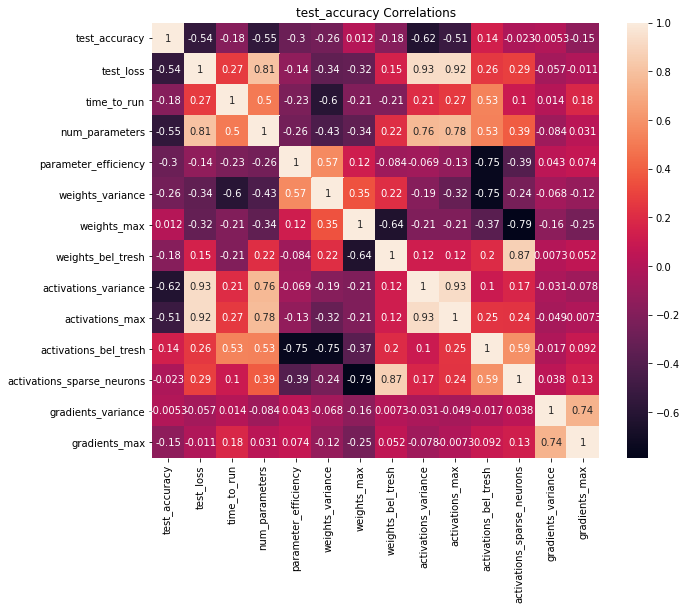

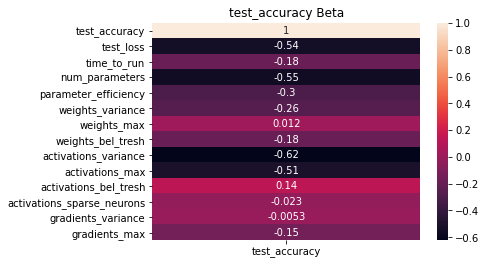

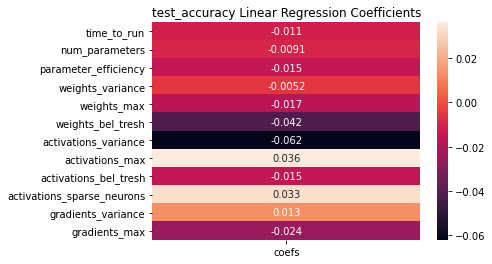

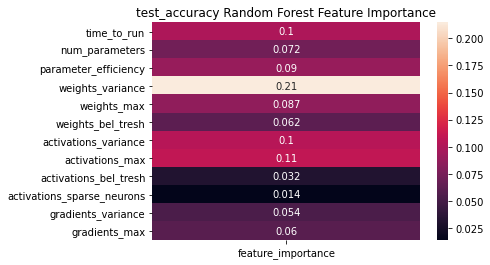

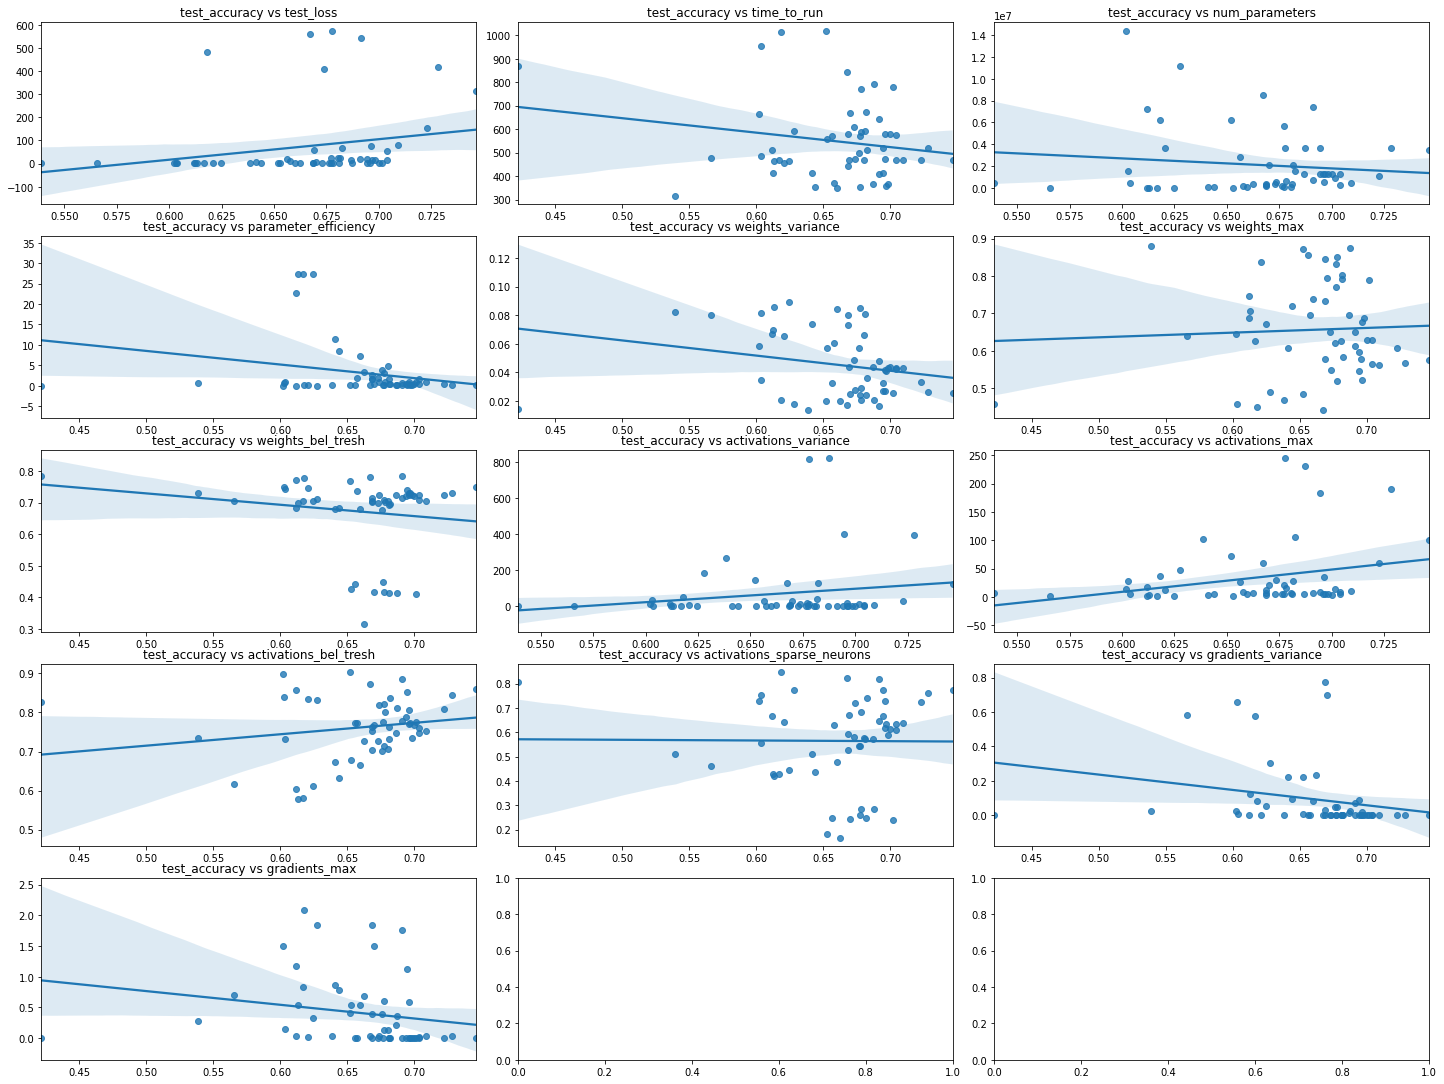

In [0]:
summary_analysis(df_summary, 'test_accuracy', 'time_to_run', 'test_accuracy')

The Linear Regression R2 is 0.918
The Random Forest R2 is 0.964


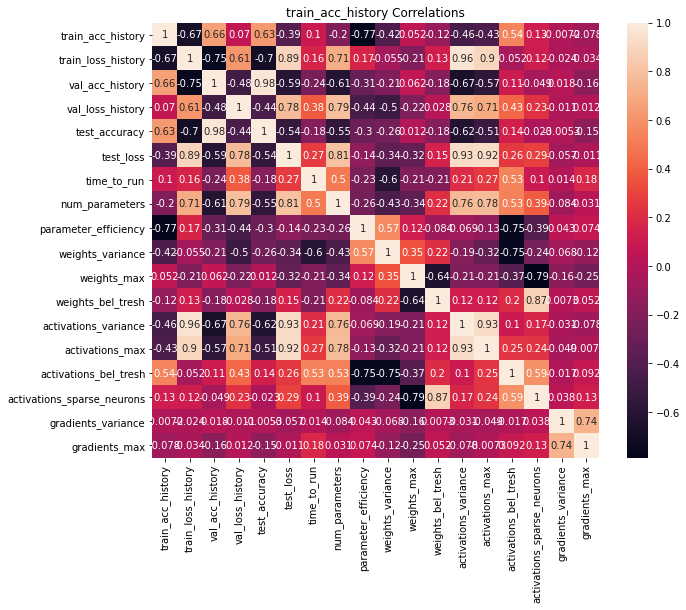

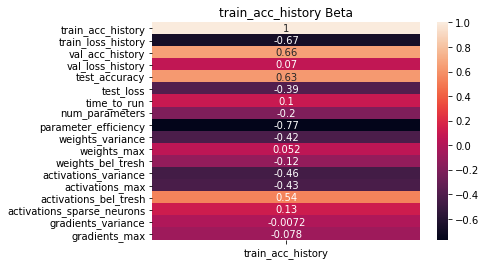

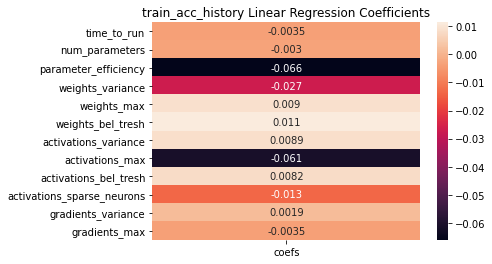

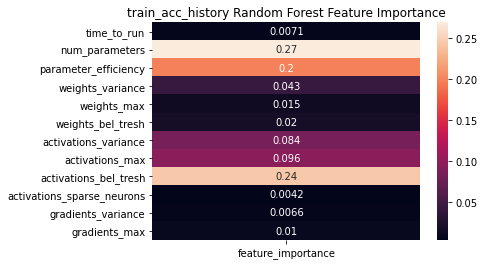

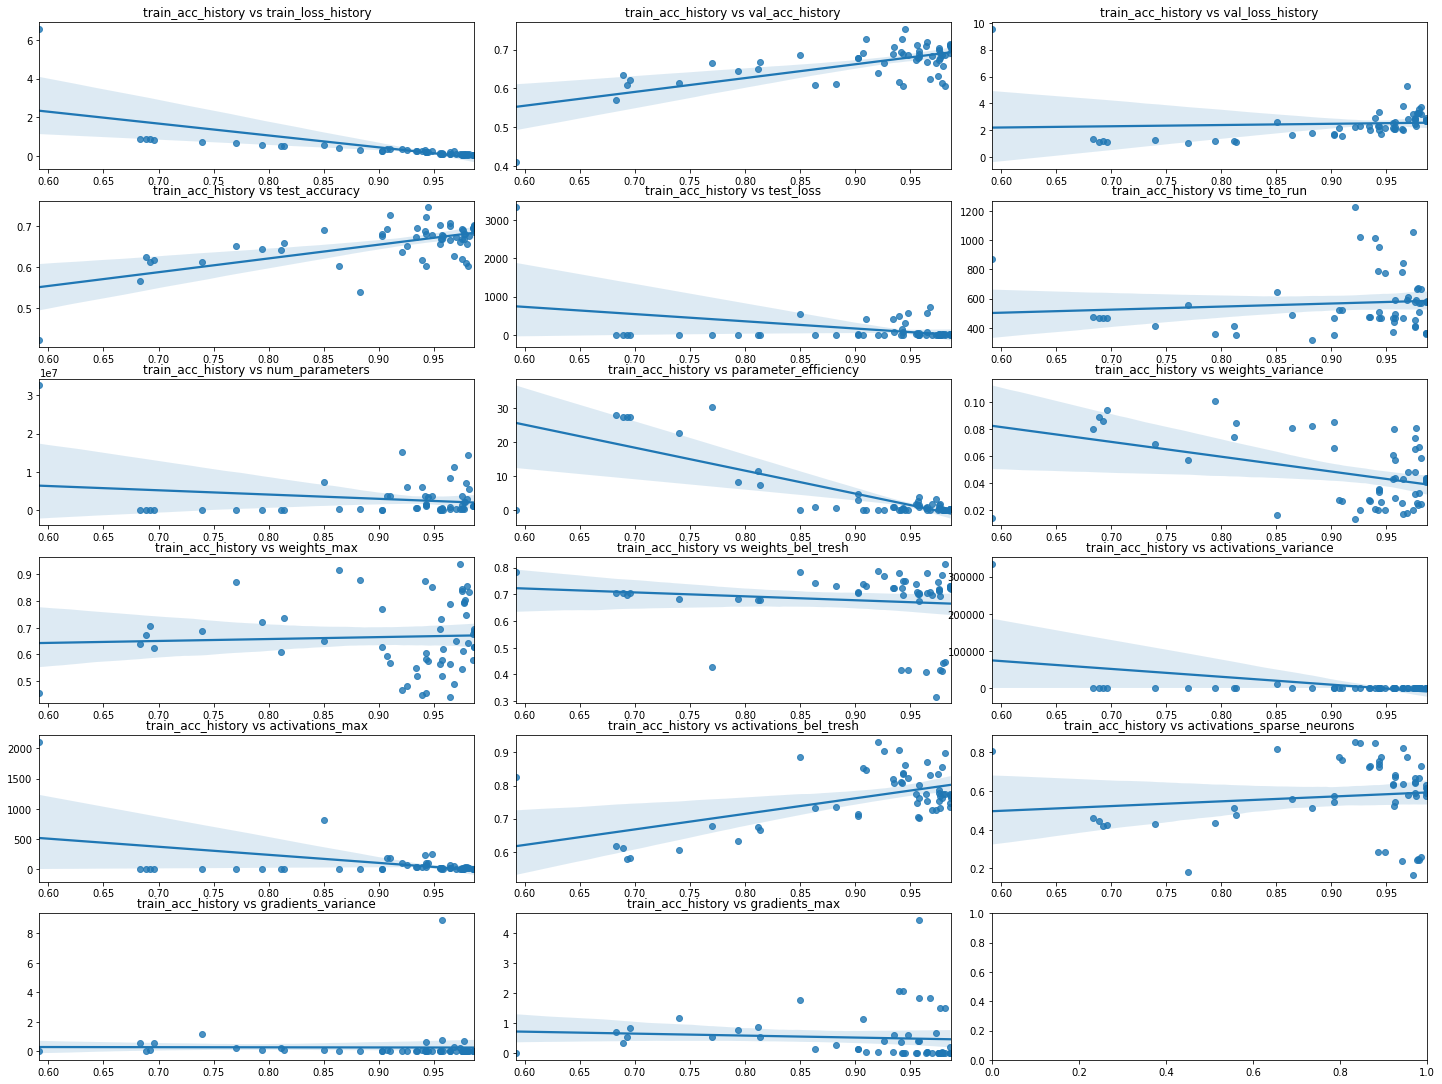

In [0]:
summary_analysis(df_summary, 'train_acc_history', 'time_to_run', 'train_acc_history')

weights_variance
The Linear Regression R2 is 0.542
The Random Forest R2 is 0.865
weights_max
The Linear Regression R2 is 0.469
The Random Forest R2 is 0.836
weights_bel_tresh
The Linear Regression R2 is 0.854
The Random Forest R2 is 0.879
activations_variance
The Linear Regression R2 is 0.902
The Random Forest R2 is 0.805
activations_max
The Linear Regression R2 is 0.875
The Random Forest R2 is 0.861
activations_bel_tresh
The Linear Regression R2 is 0.697
The Random Forest R2 is 0.804
activations_sparse_neurons
The Linear Regression R2 is 0.692
The Random Forest R2 is 0.824
gradients_variance
The Linear Regression R2 is 0.967
The Random Forest R2 is 0.875
gradients_max
The Linear Regression R2 is 0.942
The Random Forest R2 is 0.837


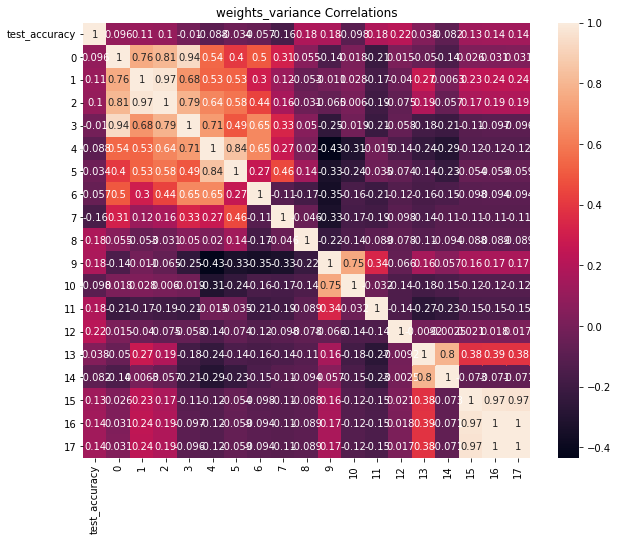

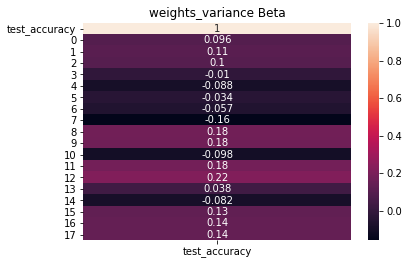

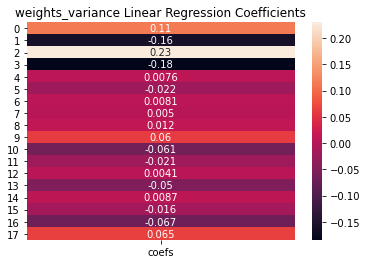

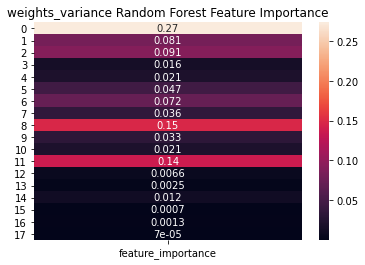

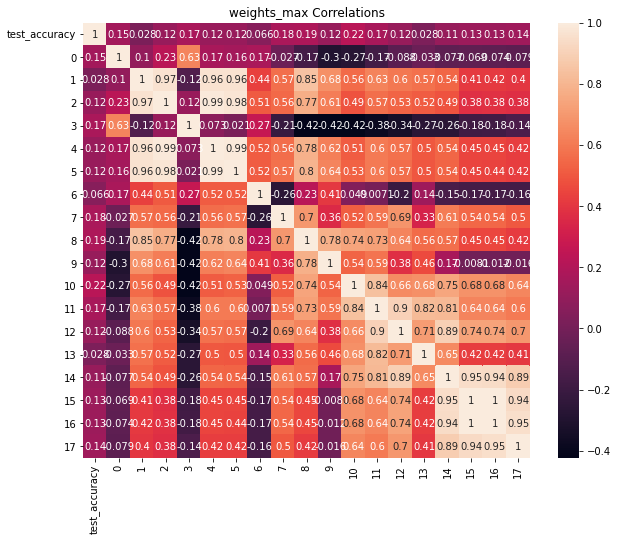

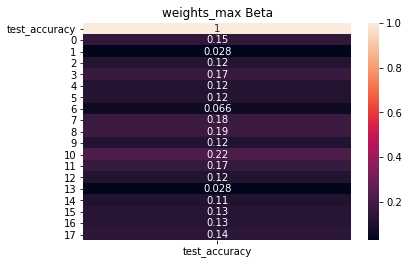

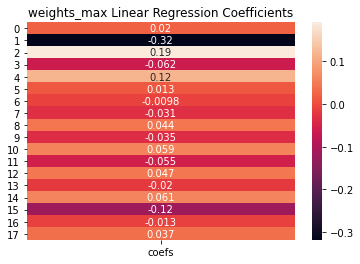

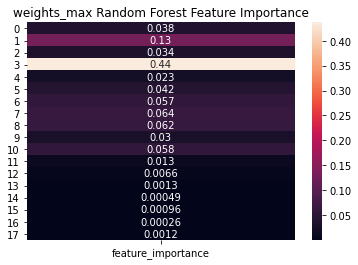

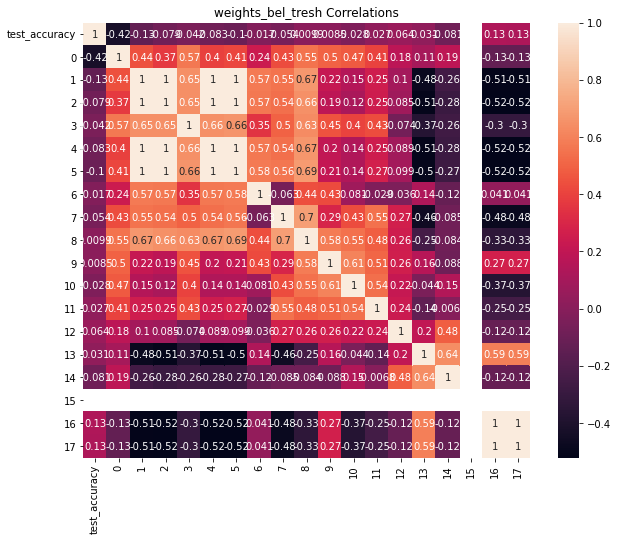

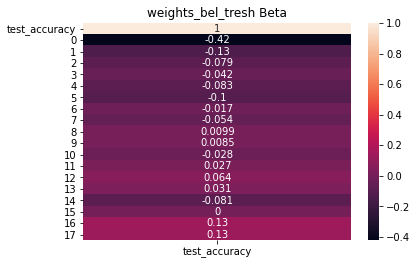

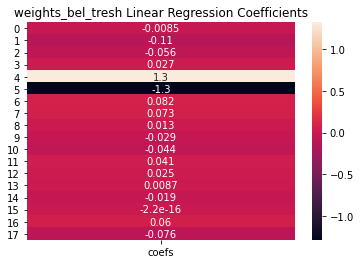

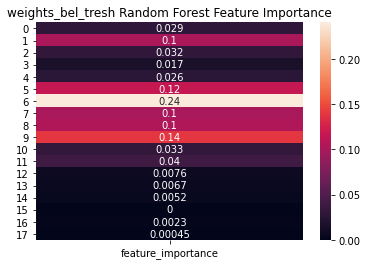

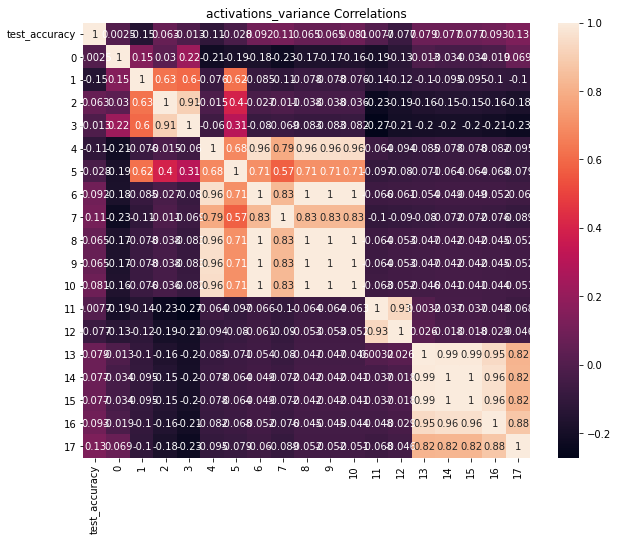

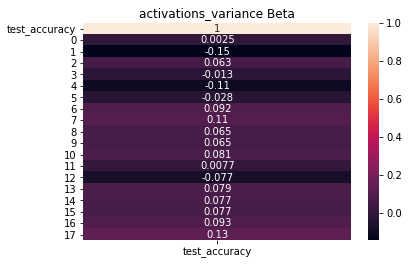

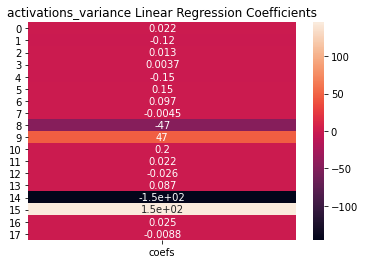

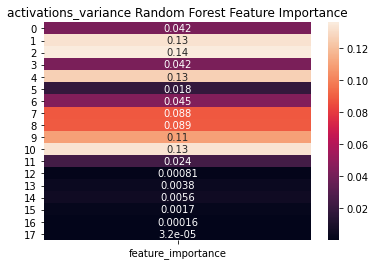

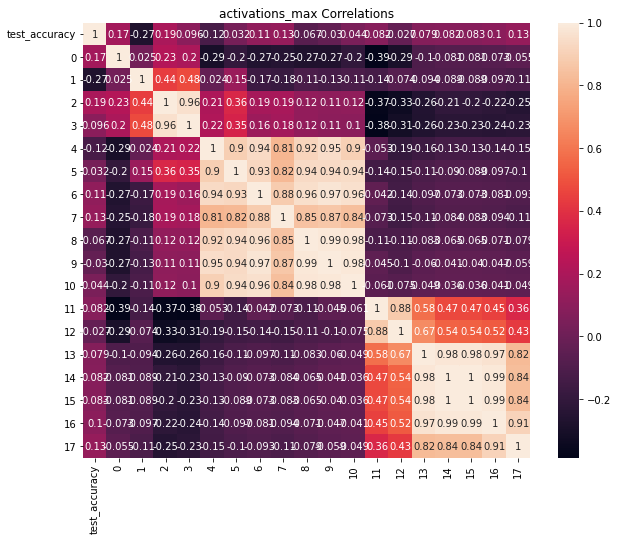

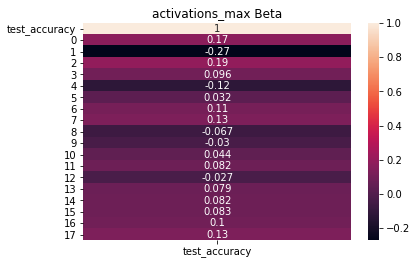

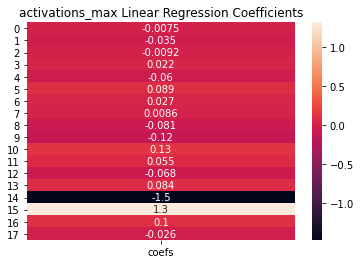

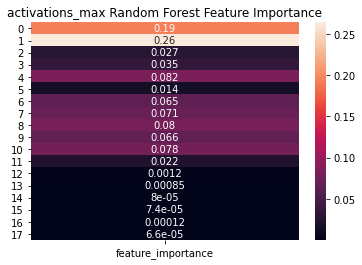

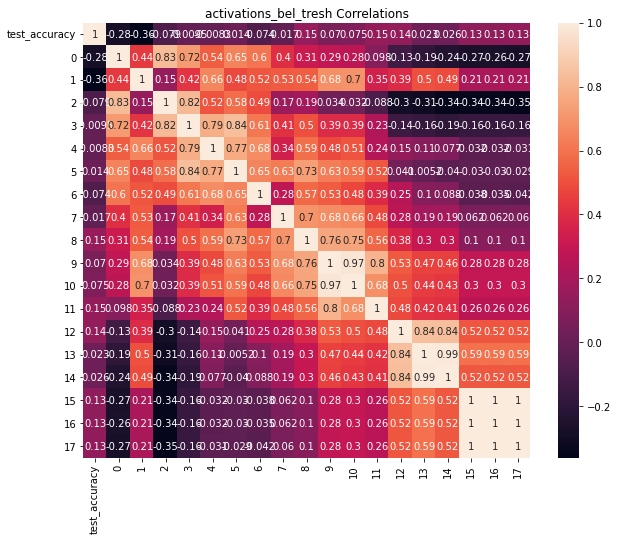

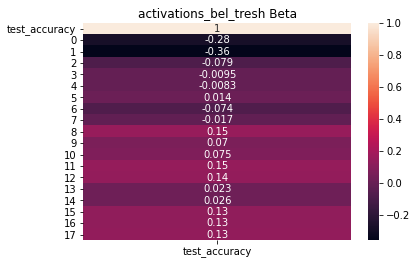

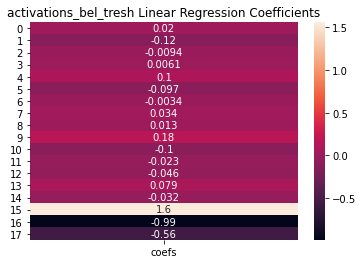

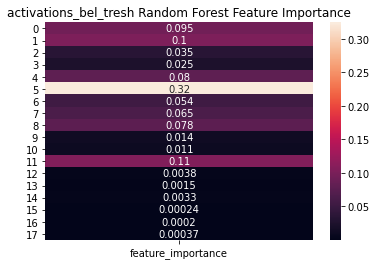

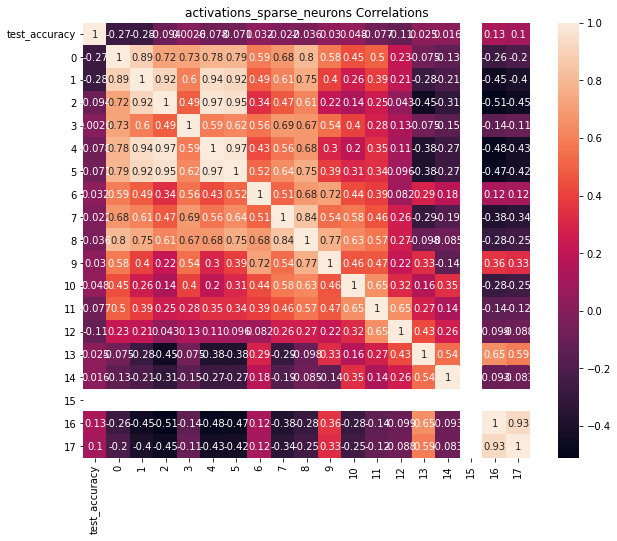

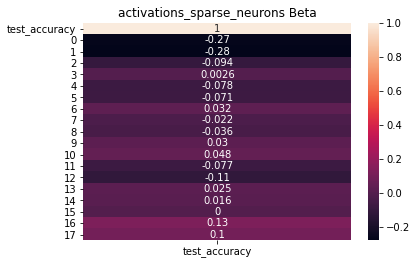

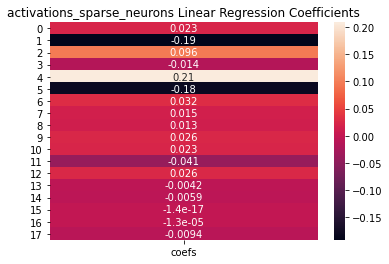

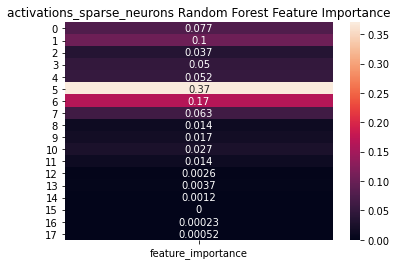

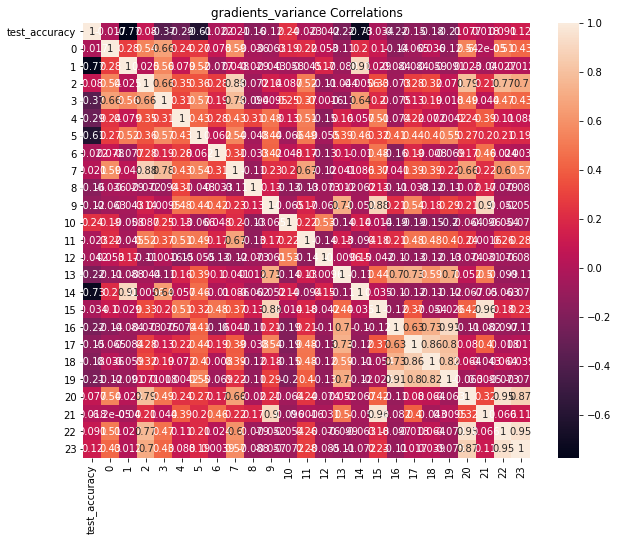

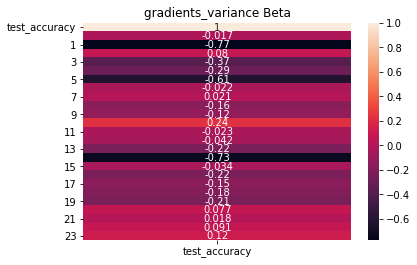

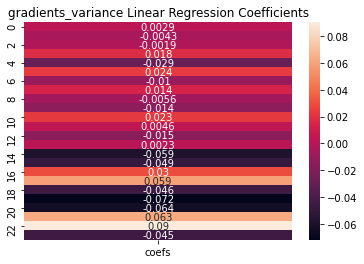

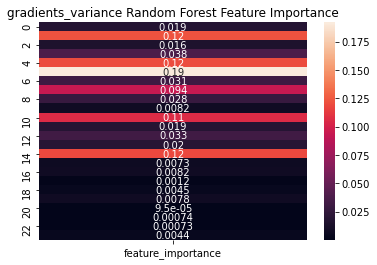

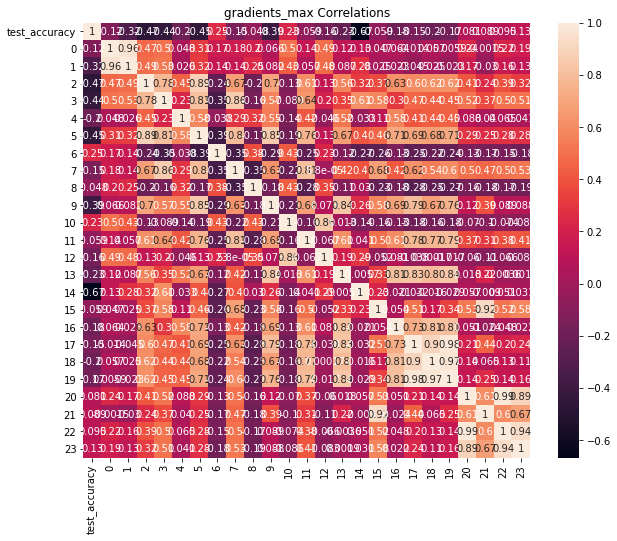

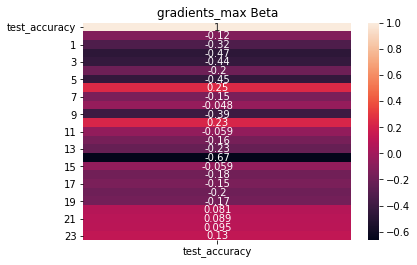

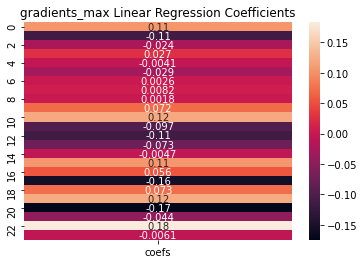

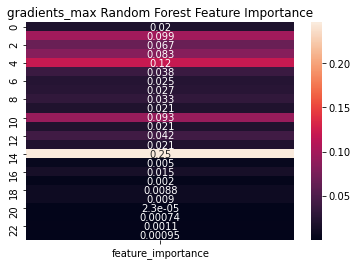

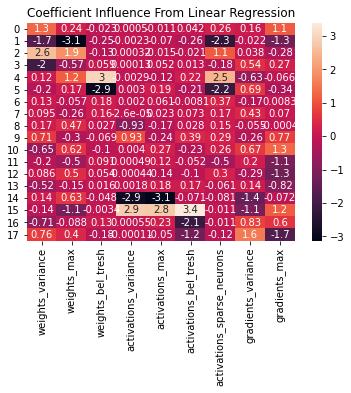

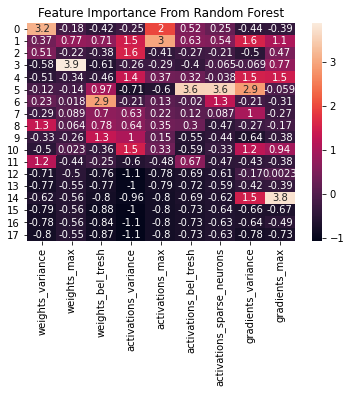

In [0]:
plot_statistics_results(layer_summary, y_results, 'test_accuracy', 1)

In [0]:
def scrape_model_summaries():
    dir_path = base_dir + 'tests/'
    file_dir = os.listdir(dir_path)
    df = pd.DataFrame()
    tests = []
    cnn_num_layers = []
    dense_num_layers = []
    cnn_neurons = []
    dense_neurons = []
    l2 = []
    l1 = []
    dropout = []
    batch_normalization = []
    cnn_neuron_layers = pd.DataFrame()
    dense_neuron_layers = pd.DataFrame()
    for test in file_dir:
        if 'summary' in test:
            pass
        else:
            file_path = os.path.join(dir_path, test, 'model_summary.txt')
            if os.path.exists(file_path):
                with open(file_path) as fp:
                    model_summary = fp.readlines()
                
                layers_neurons = pd.DataFrame()
                tests.append(test)
                cnn_layers = 0
                cnn_neurons_num = 0
                dense_layers = 0
                dense_neurons_num = 0
                l2_layers = False
                l1_layers = False
                do_layers = False
                bn_layers = False
                cnn_neuron_layer = []
                dense_neuron_layer = []
                reg_dict = {}
                for row in model_summary:
                    if 'conv2d' in row:
                        cnn_layers += 1
                        cnn_neuron = row.split(',')[3].split(')')[0].strip(' ')
                        cnn_neurons_num += int(cnn_neuron)
                        cnn_neuron_layer.append(cnn_neuron)
                    elif 'dense' in row:
                        dense_layers += 1
                        dense_neuron = row.split(',')[1].split(')')[0].strip(' ')
                        dense_neurons_num += int(dense_neuron)
                        dense_neuron_layer.append(dense_neuron)
                regularizations = ['l2', 'l1', 'do', 'do', 'bn']
                for reg in regularizations:
                    if reg in test:
                        reg_dict[reg] = True
                    else:
                        reg_dict[reg] = False
                cnn_num_layers.append(cnn_layers)
                dense_num_layers.append(dense_layers)
                cnn_neurons.append(cnn_neurons_num)
                dense_neurons.append(dense_neurons_num)
                l2.append(reg_dict['l2'])
                l1.append(reg_dict['l1'])
                dropout.append(reg_dict['do'])
                batch_normalization.append(reg_dict['bn'])
                cnn_neuron_layer = pd.DataFrame(cnn_neuron_layer, columns = [test]).T
                dense_neuron_layer = pd.DataFrame(dense_neuron_layer, columns = [test]).T
            cnn_neuron_layers = pd.concat([cnn_neuron_layers, cnn_neuron_layer])
            dense_neuron_layers = pd.concat([dense_neuron_layers, dense_neuron_layer])
    df['cnn_num_layers'] = cnn_num_layers
    df['dense_num_layers'] = dense_num_layers
    df['cnn_neurons'] = cnn_neurons
    df['dense_neurons'] = dense_neurons
    df['l2'] = l2
    df['l1'] = l1
    df['dropout'] = dropout
    df['batch_normalization'] = batch_normalization
    df.index = tests
    return df, cnn_neuron_layers, dense_neuron_layers


In [0]:
scraped_summaries, cnn_neuron_layers, dense_neuron_layers = scrape_model_summaries()

In [0]:
def stats_hyperparameter_relations(df_summary, hyperparameters, statistic):
    statistic_to_test = pd.DataFrame(df_summary[statistic])
    df_all = statistic_to_test.join(hyperparameters)
    df_all.fillna(0, inplace=True)
    summary_analysis(df_all, statistic, 1, statistic)

The Linear Regression R2 is 0.086
The Random Forest R2 is 0.791


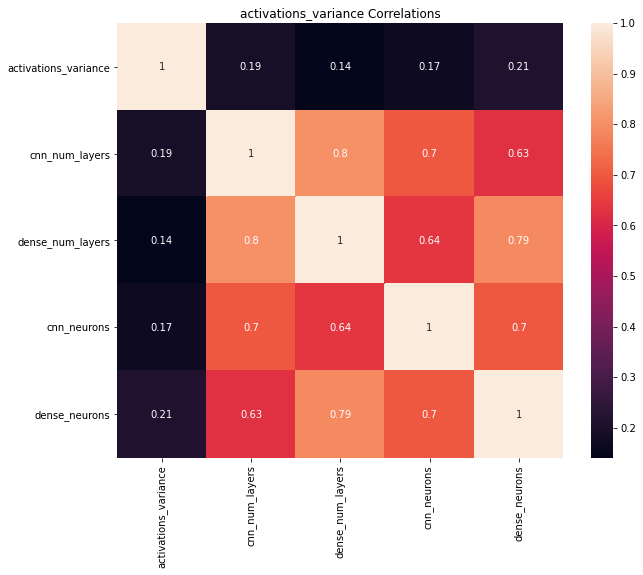

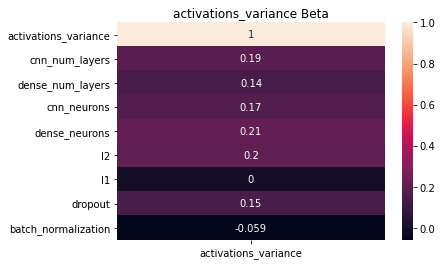

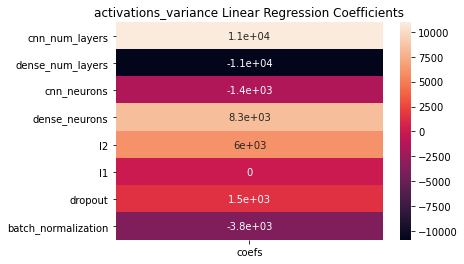

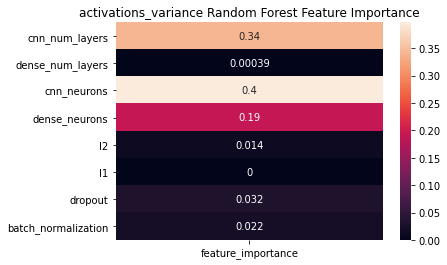

In [0]:
stats_hyperparameter_relations(df_summary, scraped_summaries, 'activations_variance')

The Linear Regression R2 is 0.228
The Random Forest R2 is 0.869


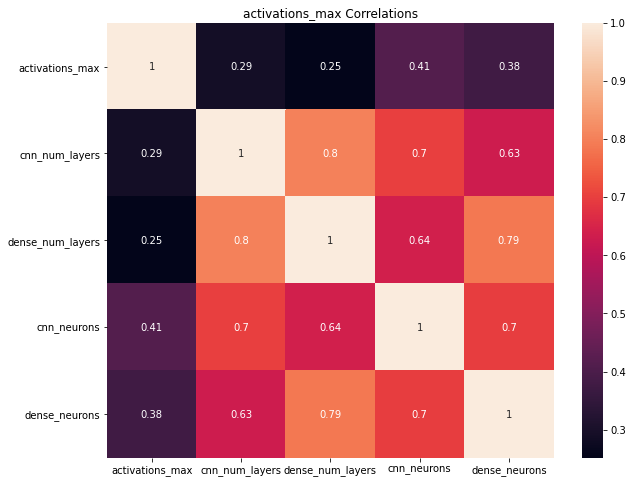

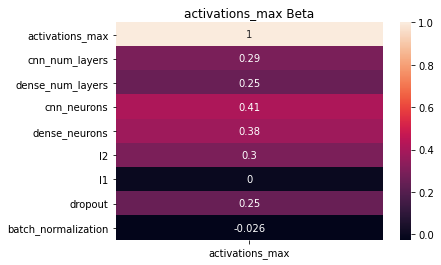

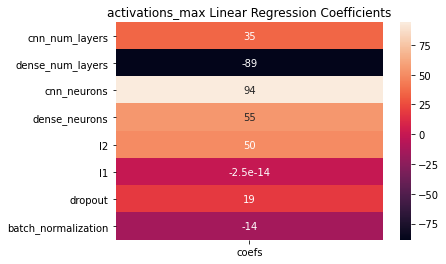

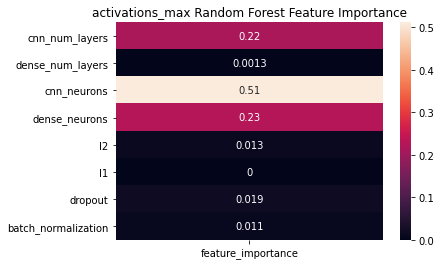

In [0]:
stats_hyperparameter_relations(df_summary, scraped_summaries, 'activations_max')

The Linear Regression R2 is 0.643
The Random Forest R2 is 0.764


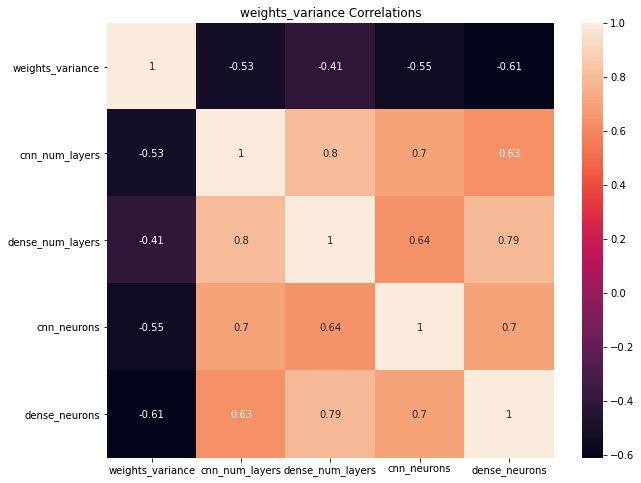

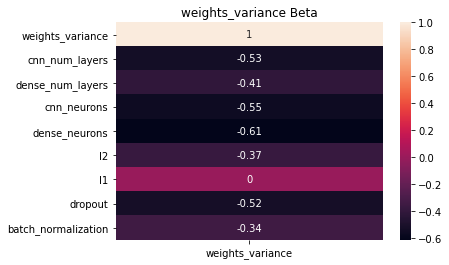

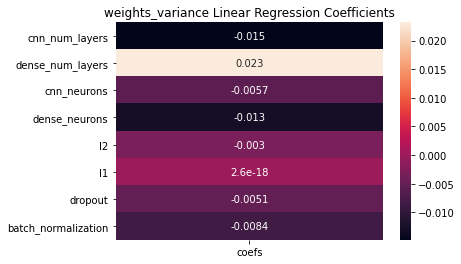

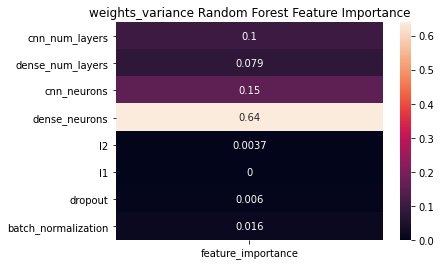

In [0]:
stats_hyperparameter_relations(df_summary, scraped_summaries, 'weights_variance')

The Linear Regression R2 is 0.245
The Random Forest R2 is 0.478


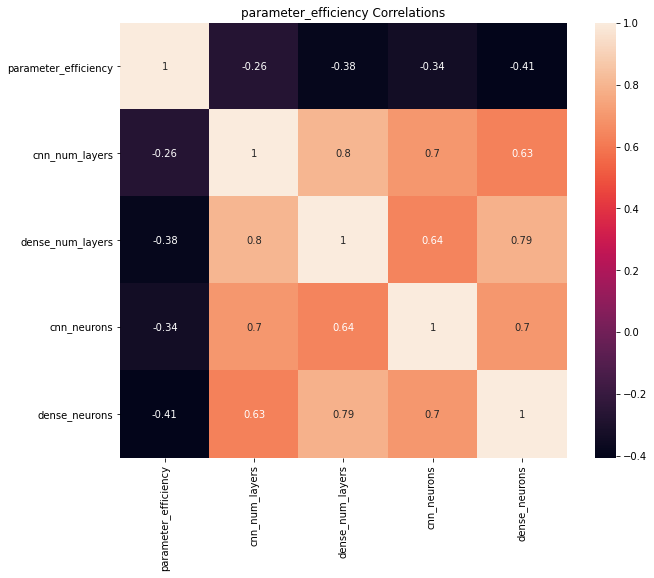

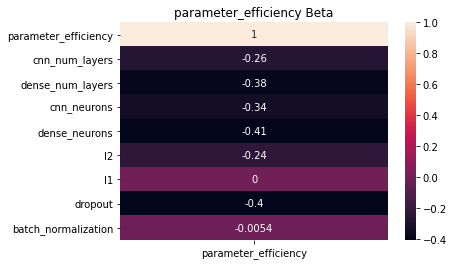

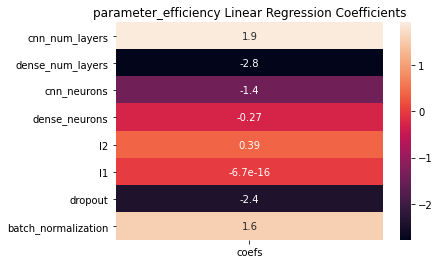

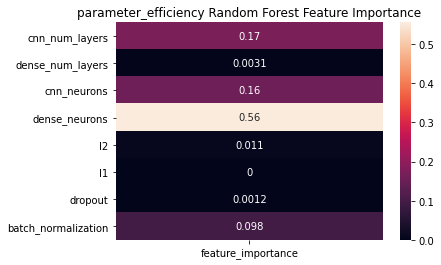

In [0]:
stats_hyperparameter_relations(df_summary, scraped_summaries, 'parameter_efficiency')